# Querying a SQLite Database from Python

In [27]:
%matplotlib inline

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from pathlib import Path

In [28]:
data_path = Path.home() / "datasets" / "tabular_practice"

conn = sqlite3.connect(data_path / "world_population.db")
print(f"OK, connection is open: {conn}")
conn.close()

OK, connection is open: <sqlite3.Connection object at 0x2804f96c0>


We can run a query against the database and return the result as a `pandas` dataframe.

In [29]:
conn = sqlite3.connect(data_path / "world_population.db")

query = "SELECT * FROM population;"
results = pd.read_sql_query(query, conn)
conn.close()
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17301 entries, 0 to 17300
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CountryCode       17301 non-null  object 
 1   CountryName       17301 non-null  object 
 2   Year              17301 non-null  int64  
 3   Population        17301 non-null  float64
 4   PopulationMale    17301 non-null  float64
 5   PopulationFemale  17301 non-null  float64
 6   PopDensity        17301 non-null  float64
 7   PopSexRatio       17301 non-null  float64
 8   MedianAge         17301 non-null  float64
 9   PopChange         17301 non-null  float64
 10  GrowthRate        17301 non-null  float64
 11  DoublingTime      13842 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1.6+ MB


In [7]:
results.head()

,CountryCode,CountryName,Year,Population,PopulationMale,PopulationFemale,PopDensity,PopSexRatio,MedianAge,PopChange,GrowthRate,DoublingTime
0,AFG,Afghanistan,1950,7480.461,3962.260,3518.202,11.5209,112.6217,18.4029,87.800,1.174,59.0415
1,ALB,Albania,1950,1252.582,642.458,610.124,45.7180,105.2997,19.6474,36.215,2.891,23.9760
2,DZA,Algeria,1950,9019.866,4613.613,4406.253,3.7871,104.7060,18.3533,254.148,2.818,24.5971
3,ASM,American Samoa,1950,19.032,9.879,9.153,95.1625,107.9259,15.5106,0.631,3.316,20.9031
4,AND,Andorra,1950,6.005,2.890,3.115,12.7755,92.7608,30.8396,0.113,1.882,36.8303


In [8]:
results["CountryCode"].value_counts()

CountryCode
AFG    73
PNG    73
NZL    73
NIC    73
NER    73
       ..
GIB    73
GRC    73
GRL    73
GRD    73
ZWE    73
Name: count, Length: 237, dtype: int64

In [9]:
17301/73

237.0

In [10]:
results["Year"].value_counts()

Year
1950    237
1987    237
2003    237
2002    237
2001    237
       ... 
1974    237
1973    237
1972    237
1971    237
2022    237
Name: count, Length: 73, dtype: int64

<Axes: xlabel='Year', ylabel='Population'>

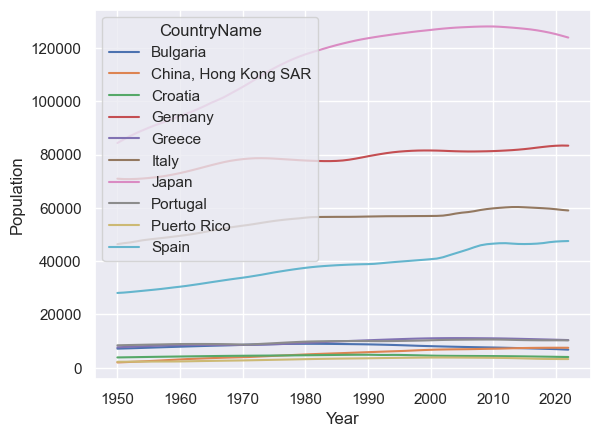

In [20]:
name = "CountryCode"
country_codes = list(results.query("Year == 2021 and Population > 1000").sort_values("MedianAge", ascending=False).head(10)[name])

regex = "|".join(country_codes)
indicator = results[name].str.contains(regex)
subset_results = results[indicator]

sns.set_theme(style="darkgrid")
sns.lineplot(
    data=subset_results,
    x="Year",
    y="Population",
    hue="CountryName",
)

In [22]:
cols = ["CountryCode", "CountryName", "Year"]
parts = []
for name, gender in [("PopulationMale", "male"), ("PopulationFemale", "female")]:
    part = subset_results[cols + [name]].rename({name: "Population"}, axis=1)
    part["Gender"] = gender
    parts.append(part)
subset_with_gender = pd.concat(parts, ignore_index=True)
subset_with_gender.head()

,CountryCode,CountryName,Year,Population,Gender
0,BGR,Bulgaria,1950,3532.072,male
1,HKG,"China, Hong Kong SAR",1950,1018.471,male
2,HRV,Croatia,1950,1839.150,male
3,DEU,Germany,1950,32442.329,male
4,GRC,Greece,1950,3736.961,male


<Axes: xlabel='Year', ylabel='Population'>

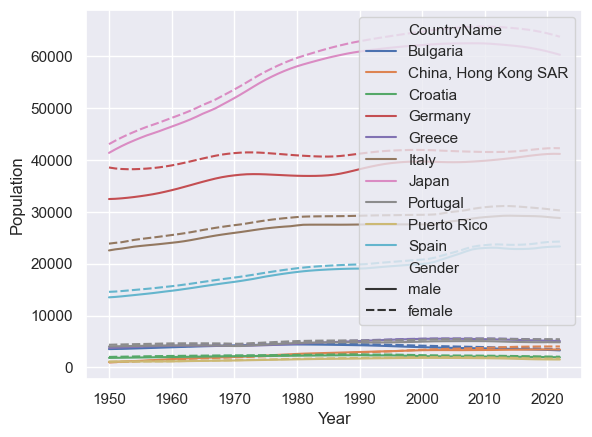

In [23]:
sns.lineplot(
    data=subset_with_gender,
    x="Year",
    y="Population",
    hue="CountryName",
    style="Gender",
)

Here is a more specific query, involving a join and grouping.

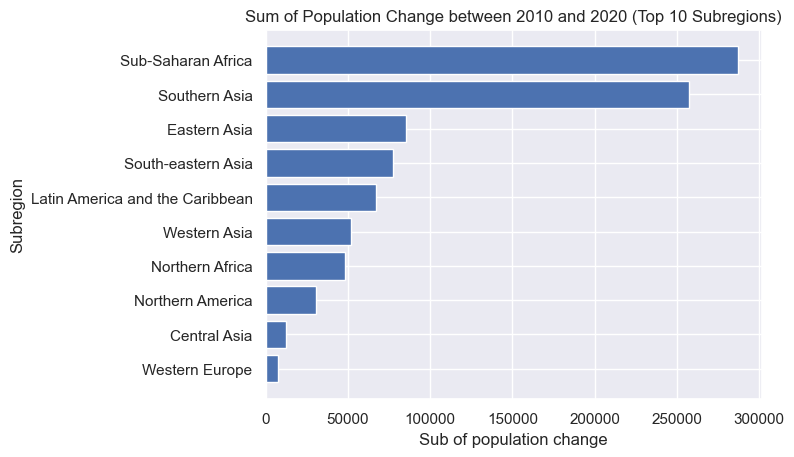

In [26]:
# Connect to the SQLite database
conn = sqlite3.connect(data_path / "world_population.db")

# Execute a SELECT query
query = """
    SELECT c.SubRegion, SUM(p.PopChange) AS sum_popchange
      FROM population AS p
      JOIN country_mapping AS c
        ON p.CountryCode = c.CountryCode AND p.Year BETWEEN 2010 AND 2020
     GROUP BY c.Region, c.SubRegion
     ORDER BY sum_popchange DESC
     LIMIT 10;
"""

# Retrieve the results of the query as a pandas dataframe
data = pd.read_sql_query(query, conn).sort_values("sum_popchange")

plt.barh(data["SubRegion"], data["sum_popchange"])
plt.xlabel("Sub of population change")
plt.ylabel("Subregion")
plt.title("Sum of Population Change between 2010 and 2020 (Top 10 Subregions)")
plt.show()

conn.close()